In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import sklearn
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
train = pd.read_json("train.jsonl",lines=True)
dev = pd.read_json("dev.jsonl",lines=True)
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [5]:
del train['id']
del train['img']
train.head()

,label,text
0,0,its their character not their color that matters
1,0,don't be afraid to love again everyone is not ...
2,0,putting bows on your pet
3,0,i love everything and everybody! except for sq...
4,0,"everybody loves chocolate chip cookies, even h..."


In [6]:
del dev['id']
del dev['img']
dev.head()

,label,text
0,1,white people is this a shooting range
1,1,bravery at its finest
2,1,your order comes to $37.50 and your white priv...
3,1,it is time.. to send these parasites back to t...
4,1,mississippi wind chime


In [7]:
# functions to pre process text data : 
# 1. remove stopwords
# 2. remove punctuation

def stop_words(df, column, new_column):
  df[new_column]=df[column].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words('english')]))
  return df

def punctuation(df, column, new_column):
  df[new_column]=df[column].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
  return df

In [8]:
cleaned_train = stop_words(train, 'text', 'cleaned_text')
cleaned_train = punctuation(cleaned_train, 'cleaned_text', 'cleaned_text')
cleaned_train.head()

,label,text,cleaned_text
0,0,its their character not their color that matters,character color matters
1,0,don't be afraid to love again everyone is not ...,afraid love everyone like ex
2,0,putting bows on your pet,putting bows pet
3,0,i love everything and everybody! except for sq...,love everything everybody except squirrels hat...
4,0,"everybody loves chocolate chip cookies, even h...",everybody loves chocolate chip cookies even hi...


In [9]:
cleaned_dev = stop_words(dev, 'text', 'cleaned_text')
cleaned_dev = punctuation(cleaned_dev, 'cleaned_text', 'cleaned_text')
cleaned_dev.head()

,label,text,cleaned_text
0,1,white people is this a shooting range,white people shooting range
1,1,bravery at its finest,bravery finest
2,1,your order comes to $37.50 and your white priv...,order comes 3750 white privilege discount brin...
3,1,it is time.. to send these parasites back to t...,time send parasites back desert
4,1,mississippi wind chime,mississippi wind chime


In [10]:
text_train = cleaned_train.cleaned_text.values
labels_train = cleaned_train.label.values

print("shape of input", text_train.shape)
print("shape of labels", labels_train.shape)

shape of input (8500,)
shape of labels (8500,)


In [11]:
print("Text input", text_train)
print("Text labels", labels_train)

Text input ['character color matters' 'afraid love everyone like ex'
 'putting bows pet' ...
 'gays social media equality body positivity love love love gays real life place social circle'
 'bad day could siamese twin attached gay brother date one ass'
 'hate muslims take religion seriously pathetic weaklings']
Text labels [0 0 0 ... 1 1 1]


In [12]:
text_dev = cleaned_dev.cleaned_text.values
labels_dev = cleaned_dev.label.values

print("shape of input", text_dev.shape)
print("shape of labels", labels_dev.shape)

shape of input (500,)
shape of labels (500,)


In [13]:
print("Text input", text_dev)
print("Text labels", labels_dev)

Text input ['white people shooting range' 'bravery finest'
 'order comes 3750 white privilege discount brings total 3750'
 'time send parasites back desert' 'mississippi wind chime'
 'knowing white people  thats probably baby father'
 'life hack 23 get stoned weed' 'heard elf shelf get ready'
 'cooooooooooooon' 'get choose mental illness' 'dat ass ahmarbkrichd'
 'look says right here fuck goats'
 'enough enough children important freaks'
 'removes polish chemicals nobody bats eye removes polish chemicals everybody loses shit'
 '80 point iq highest village' 'sense humor dark picks cotton'
 'offends might lack toes intolerant'
 'yes know trump said mexico pay wall mexicans wall boy good'
 'wash ass water eat daughters ass' 'safe sex isis style'
 'hurry barack home soon' 'white people cinco de mayo vs every day'
 'ww2 jewish prisoner trying escape auchschwitz showers 1943 colorized wwii jew escaping hitlers rath'
 'one tranny problems'
 'whatsthe difference heroin i cops think twice shoot

In [14]:
train_input, val_input = text_train, text_dev
train_label, val_label = labels_train, labels_dev

In [15]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
print('Actual text :', text_train[1])
print('Tokens :', tokenizer.tokenize(text_train[1]))
print('Token to ids :',tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_train[1])))

Actual text : afraid love everyone like ex
Tokens : ['afraid', 'love', 'everyone', 'like', 'ex']
Token to ids : [4452, 2293, 3071, 2066, 4654]


In [18]:
# Finding the maximum length
max_len_train = 0

for text in text_train :
  max_len_train = max(max_len_train, len(text))

print('Max sentence length :', max_len_train)

Max sentence length : 336


In [19]:
# Finding the maximum length
max_len_dev = 0

for text in text_dev :
  max_len_dev = max(max_len_dev, len(text))

print('Max sentence length :', max_len_dev)

Max sentence length : 151


In [20]:
def mask_inputs_for_bert(text,max_len):
  input_ids = []
  attention_masks = []
  i = 0
  for t in text : 
    if (i<3):  # on affiche les 3 premiers textes
      print("text :", t)
    encoded_dict =  tokenizer.encode_plus(t, add_special_tokens = True, max_length = max_len, pad_to_max_length = True, return_attention_mask = True)
    if (i<3): # on affiche les 3 premiers textes tokenizés
      print('dict :', encoded_dict['input_ids'])
      print('attention masks :', encoded_dict['attention_mask'])
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    i += 1
  # convert totensor and return
  input_ids = tf.convert_to_tensor(input_ids)
  attention_masks = tf.convert_to_tensor(attention_masks)
  return input_ids,attention_masks

In [21]:
train_inp, train_mask = mask_inputs_for_bert(train_input,max_len_train)
val_inp, val_mask = mask_inputs_for_bert(val_input,max_len_dev)
train_label = tf.convert_to_tensor(train_label)
val_label = tf.convert_to_tensor(val_label)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


text : character color matters
dict : [101, 2839, 3609, 5609, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


text : white people shooting range
dict : [101, 2317, 2111, 5008, 2846, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention masks : [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text : bravery f

In [22]:
print("Train_input_shape : ", train_inp.shape)
print("Train_mask_shape : ", train_mask.shape)
print("Validation_input_shape : ", val_inp.shape)
print("Validation_mask_shape : ", val_mask.shape)
print("Train_label_shape : ", train_label.shape)
print("Validation_label_shape : ", val_label.shape)

Train_input_shape :  (8500, 336)
Train_mask_shape :  (8500, 336)
Validation_input_shape :  (500, 151)
Validation_mask_shape :  (500, 151)
Train_label_shape :  (8500,)
Validation_label_shape :  (500,)


In [23]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, return_dict=True, output_attentions = True,)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
log_dir = 'gdrive/Mydrive/Statapp'
model_save_path = 'gdrive/Mydrive/Statapp/bert_model.hdf5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path,\
                                                save_weights_only = True,\
                                                monitor = 'val_accuracy',\
                                                mode= 'min',\
                                                save_best_only = True),\
             tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=3, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None)]


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
metric2 = tf.keras.metrics.Recall(name='recall')
metric3 = tf.keras.metrics.Precision(name = 'precision')
metric4 = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6, epsilon = 1e-08, weight_decay=0.1)

bert_model.compile(loss = loss, optimizer = optimizer, metrics = [metric, metric4])

In [27]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [25]:
with tf.device('/device:GPU:0'):
  history = bert_model.fit([train_inp, train_mask],\
                         train_label,\
                         batch_size = 16,\
                         epochs = 4,\
                         validation_data = ([val_inp, val_mask], val_label))

Epoch 1/4
532/532 [==============================] - 681s 1s/step - loss: 0.6660 - accuracy: 0.5941 - val_loss: 0.7657 - val_accuracy: 0.5040
Epoch 2/4
532/532 [==============================] - 608s 1s/step - loss: 0.6084 - accuracy: 0.6796 - val_loss: 0.7581 - val_accuracy: 0.5480
Epoch 3/4
532/532 [==============================] - 608s 1s/step - loss: 0.5840 - accuracy: 0.7088 - val_loss: 0.7908 - val_accuracy: 0.5660
Epoch 4/4
532/532 [==============================] - 608s 1s/step - loss: 0.5664 - accuracy: 0.7206 - val_loss: 0.7748 - val_accuracy: 0.5740


<ipython-input-27-ff34c960b42d>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


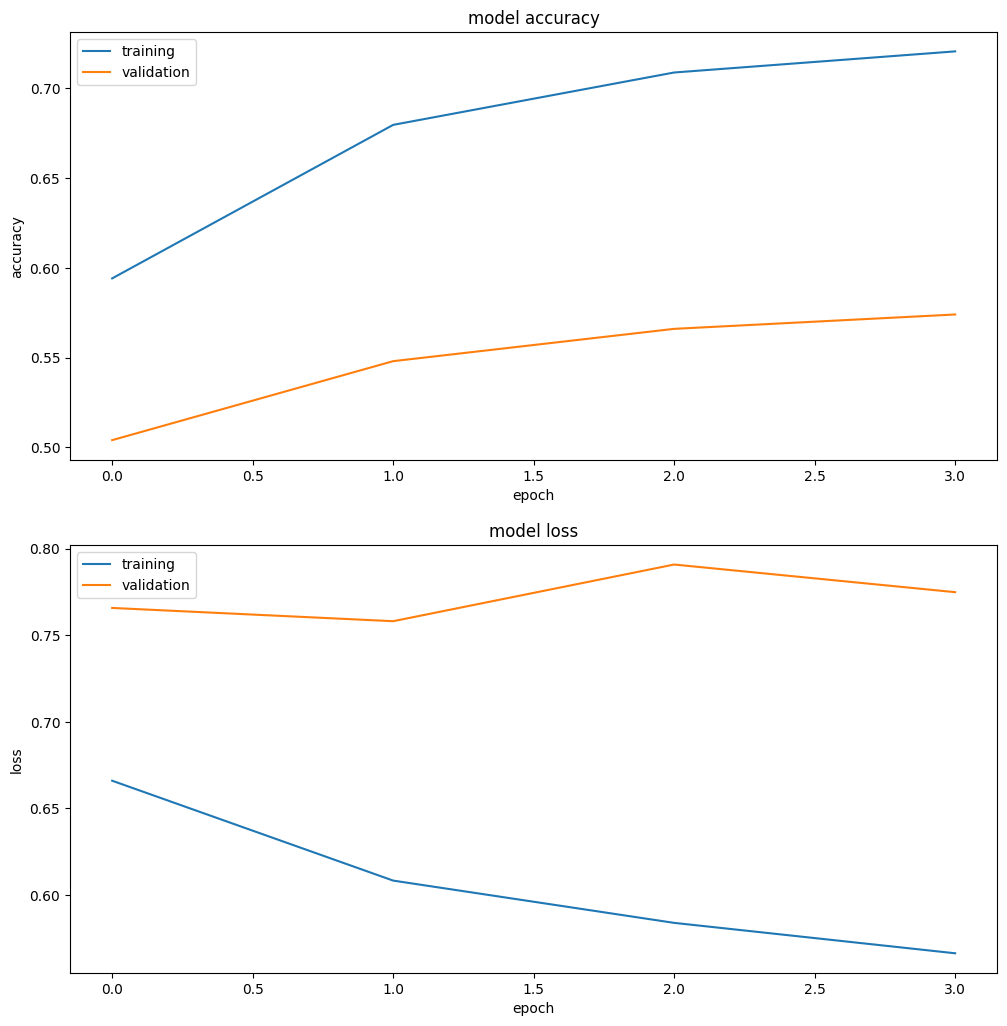

In [27]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [39]:
bert_model.save_weights('gdrive/Mydrive/Statapp/bert_model.hdf5', overwrite=True)

In [52]:
import h5py
filedirectory = "gdrive/Mydrive/Statapp/bert_model.hdf5"

with h5py.File(filedirectory, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    print(f['top_level_model_weights'])


Keys: <KeysViewHDF5 ['bert', 'classifier', 'dropout_37', 'top_level_model_weights']>
<HDF5 group "/top_level_model_weights" (0 members)>


In [ ]:
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key]))
    print(f[a_group_key])
    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])
    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    #ds_arr = f[a_group_key][()]  # returns as a numpy array  

In [31]:
with tf.device('/device:GPU:0'):
  history = bert_model.fit([train_inp, train_mask],\
                         train_label,\
                         batch_size = 16,\
                         epochs = 5,\
                         validation_data = ([val_inp, val_mask], val_label),\
                         callbacks = callbacks)

Epoch 1/5
532/532 [==============================] - 655s 1s/step - loss: 0.7137 - accuracy: 0.4584 - binary_accuracy: 0.6411 - val_loss: 0.6974 - val_accuracy: 0.4780 - val_binary_accuracy: 0.5000
Epoch 2/5
532/532 [==============================] - 599s 1s/step - loss: 0.6785 - accuracy: 0.5821 - binary_accuracy: 0.6412 - val_loss: 0.7019 - val_accuracy: 0.5020 - val_binary_accuracy: 0.5000
Epoch 3/5
532/532 [==============================] - 594s 1s/step - loss: 0.6662 - accuracy: 0.6299 - binary_accuracy: 0.6412 - val_loss: 0.7095 - val_accuracy: 0.4940 - val_binary_accuracy: 0.5000
Epoch 4/5
532/532 [==============================] - 598s 1s/step - loss: 0.6577 - accuracy: 0.6389 - binary_accuracy: 0.6412 - val_loss: 0.7175 - val_accuracy: 0.4940 - val_binary_accuracy: 0.5000
Epoch 5/5
532/532 [==============================] - 599s 1s/step - loss: 0.6499 - accuracy: 0.6434 - binary_accuracy: 0.6412 - val_loss: 0.7212 - val_accuracy: 0.4980 - val_binary_accuracy: 0.5000


<ipython-input-32-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


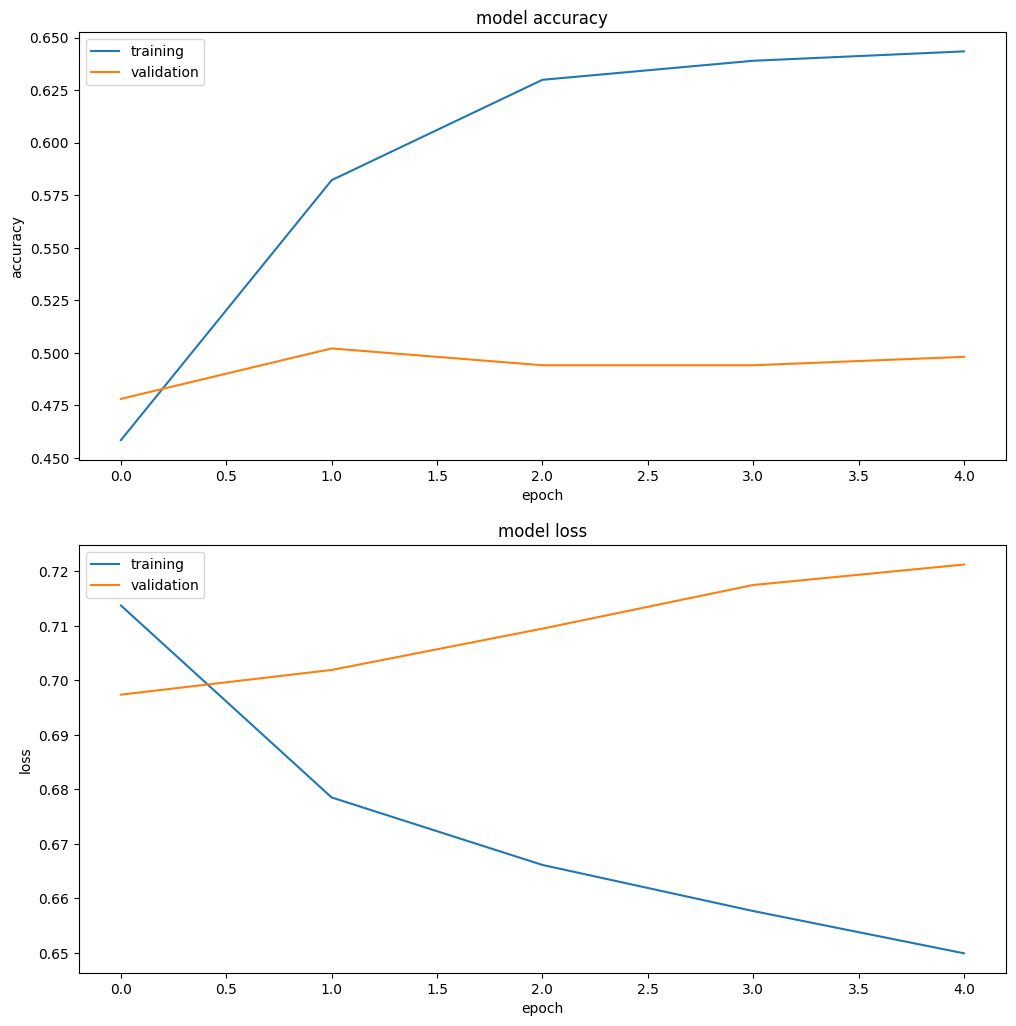

In [32]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [27]:
with tf.device('/device:GPU:0'):
  history = bert_model.fit([train_inp, train_mask],\
                         train_label,\
                         batch_size = 16,\
                         epochs = 5,\
                         validation_data = ([val_inp, val_mask], val_label),\
                         callbacks = callbacks)

Epoch 1/5
532/532 [==============================] - 675s 1s/step - loss: 0.6563 - accuracy: 0.6402 - binary_accuracy: 0.6268 - val_loss: 0.8230 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 2/5
532/532 [==============================] - 597s 1s/step - loss: 0.6561 - accuracy: 0.6414 - binary_accuracy: 0.6385 - val_loss: 0.7509 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 3/5
532/532 [==============================] - 599s 1s/step - loss: 0.6555 - accuracy: 0.6412 - binary_accuracy: 0.6320 - val_loss: 0.7333 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 4/5
532/532 [==============================] - 597s 1s/step - loss: 0.6550 - accuracy: 0.6411 - binary_accuracy: 0.6409 - val_loss: 0.7989 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 5/5
532/532 [==============================] - 597s 1s/step - loss: 0.6553 - accuracy: 0.6407 - binary_accuracy: 0.6402 - val_loss: 0.7421 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000


<ipython-input-28-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


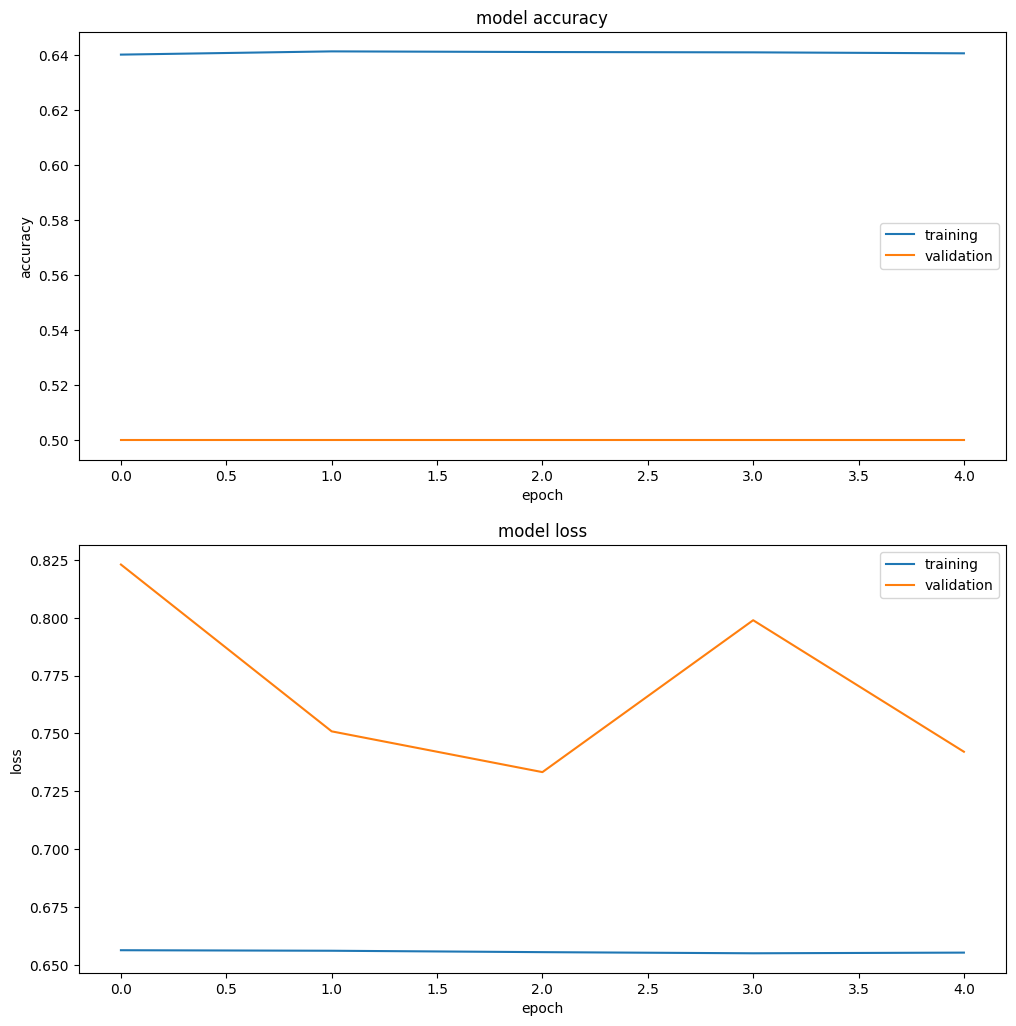

In [28]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [28]:
with tf.device('/device:GPU:0'):
  history = bert_model.fit([train_inp, train_mask],\
                         train_label,\
                         batch_size = 16,\
                         epochs = 6,\
                         validation_data = ([val_inp, val_mask], val_label),\
                         callbacks = callbacks)

Epoch 1/6
532/532 [==============================] - 679s 1s/step - loss: 0.6457 - accuracy: 0.6419 - binary_accuracy: 0.6364 - val_loss: 0.7333 - val_accuracy: 0.5100 - val_binary_accuracy: 0.5000
Epoch 2/6
532/532 [==============================] - 590s 1s/step - loss: 0.6120 - accuracy: 0.6819 - binary_accuracy: 0.6346 - val_loss: 0.7633 - val_accuracy: 0.5380 - val_binary_accuracy: 0.5020
Epoch 3/6
532/532 [==============================] - 599s 1s/step - loss: 0.5864 - accuracy: 0.7027 - binary_accuracy: 0.6220 - val_loss: 0.7545 - val_accuracy: 0.5720 - val_binary_accuracy: 0.5020
Epoch 4/6
532/532 [==============================] - 623s 1s/step - loss: 0.5671 - accuracy: 0.7221 - binary_accuracy: 0.6129 - val_loss: 0.7720 - val_accuracy: 0.5640 - val_binary_accuracy: 0.4960
Epoch 5/6
532/532 [==============================] - 596s 1s/step - loss: 0.5526 - accuracy: 0.7271 - binary_accuracy: 0.5957 - val_loss: 0.7760 - val_accuracy: 0.5640 - val_binary_accuracy: 0.4830
Epoch 6/6


<ipython-input-29-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


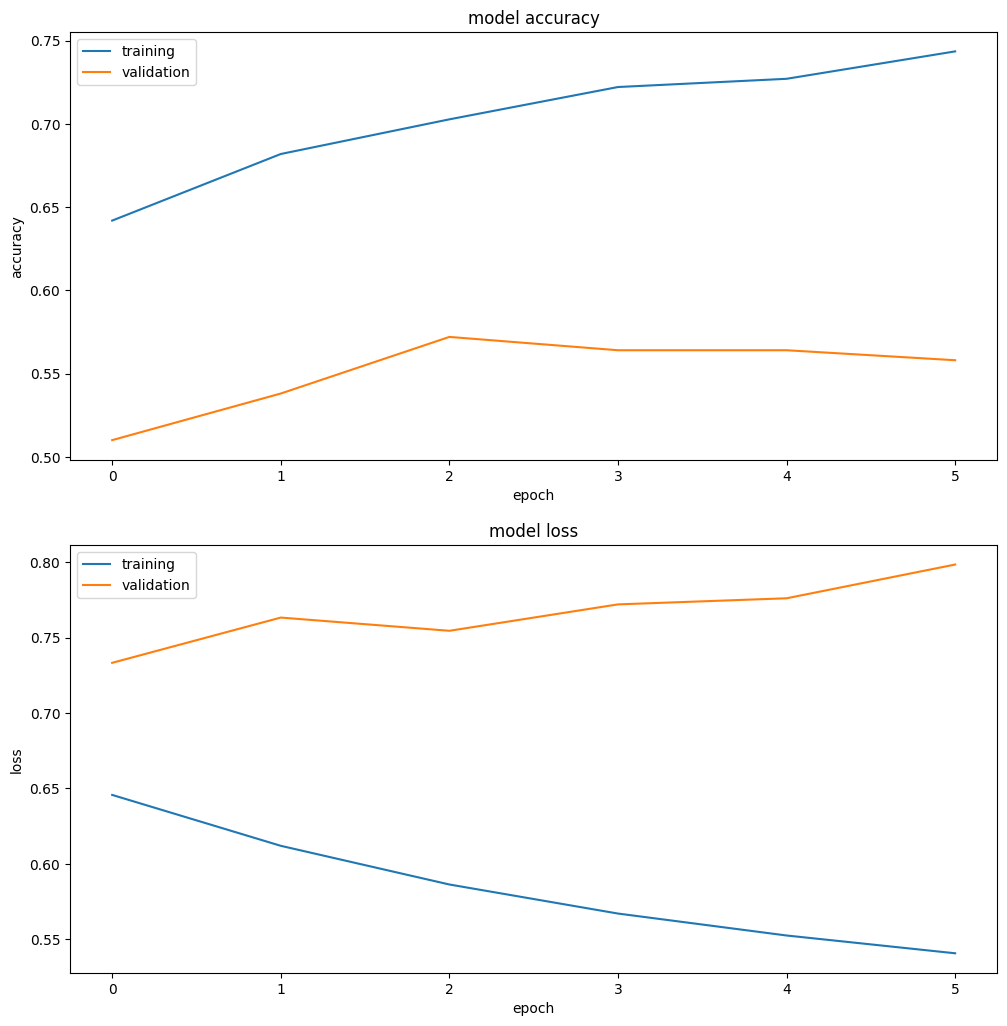

In [29]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [30]:
bert_model.save_weights('bert.hdf5')